# Capstone Project

In [5]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import metrics
import pickle

In [6]:
# Import the dataframe
df = pd.read_csv('Top 50 Excerice for your body.csv')

In [7]:
# Exlude the outlier 'Jumping Jacks' because it's significantly (1.5 x IQR) outside of Q3 for the number of reps and the number of calories it burns for its difficulty level.

index_to_remove = df[df['Reps'] == 30].index
df.drop(index = index_to_remove, inplace = True)

---

## Train Test Splitting

I will stratify the training and testing sets based on the area of the body the exercise targets. This is because it has a large effect on the number of calories burned so ensuring similar proportions are split acorss both groups is important.

In [11]:
# Create a function to split the 'Benefit' columns into 4 categories - Upper body, Lower body, Full body, Core/balance

def benefit_cat(benefit):
    
    if any(keyword in benefit for keyword in ['cardiovascular', 'full-body', 'Combines']):
        return 'Full Body'
    
    elif any(keyword in benefit for keyword in ['abs', 'balance', 'abdominal', 'core']) and 'Improves balance and leg strength' not in benefit and 'Builds unilateral leg strength and balance' not in benefit:
        return 'Core/Balance'

    elif any(keyword in benefit for keyword in ['upper', 'chest', 'triceps', 'back', 'biceps', 'shoulder']) and 'Strengthens back and legs' not in benefit:
        return 'Upper Body'
    else:
        return 'Lower Body'

In [12]:
# Split the target muscle groups into individual rows, generalise the more specific muscle groups and keep the first row (most targeted muscle)

df1 = df.copy()
df1['Benefit Category'] = df1['Benefit'].apply(benefit_cat)

In [13]:
# Split the data into the training and testing sets now stratifying on Benefit Category

X = df1[['Name of Exercise', 'Sets', 'Reps', 'Benefit', 'Target Muscle Group', 'Equipment Needed', 'Difficulty Level', 'Benefit Category']]
y = df1['Burns Calories (per 30 min)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = df1['Benefit Category'], random_state = 10)

---

## Feature Engineering

**Feature columns**
- Sets
- Total Reps
- Difficulty_Beginner
- Target_Biceps
- Target_Full Body
- Target_Glutes
- Target_Legs
- Target_Shoulders
- Target_Triceps

In [17]:
# Define a function which applies min-max scaling to the numerical columns.
# This scaling method resulted in the best model.

def scaling(df, scaled_col_names):
    df = df.copy()
    
    # List the features to be scaled
    features = df[scaled_col_names]
    
    # Fit and transform the scaler on the features to be scaled
    scaler = MinMaxScaler().fit(features)
    scaled_features = scaler.transform(features)
    df[scaled_col_names] = scaled_features
    return df

In [18]:
# Create a feature engineering function

def feature_eng(df):
    df = df.copy()
    
    # Map equipment to yes - 1 or no - 0
    df.fillna(value = 'None', inplace = True)
    df['Equipment Needed'] = df['Equipment Needed'].apply(lambda x: 0 if 'None' in x else 1)

    # OHE the difficulty level - this performs better than mapping to 0, 1, 2.
    df = pd.get_dummies(df, columns = ['Difficulty Level'], drop_first = True, prefix = 'Difficulty', dtype = int)

    # Split the target muscle groups into individual rows, generalise the more specific muscle groups and keep the first row (most targeted muscle)
    df['Target Muscle Group'] = df['Target Muscle Group'].str.split(', ')
    df = df.explode('Target Muscle Group')
    df['Target Muscle Group'] = df['Target Muscle Group'].map({'Glutes':'Glutes', 'Core':'Core', 'Shoulders': 'Shoulders', 'Legs': 'Legs',
                                                           'Triceps': 'Triceps', 'Back': 'Back', 'Biceps': 'Biceps', 'Chest': 'Chest', 
                                                           'Full Body': 'Full Body', 'Forearms': 'Forearms', 'Calves': 'Calves', 
                                                           'Hips': 'Core', 'Full Core': 'Core', 'Lower Chest': 'Chest', 'Upper Chest': 'Chest', 
                                                           'Hip Flexors': 'Core', 'Obliques': 'Core', 'Lower Back': 'Back', 'Lower Abs': 'Core', 
                                                           'Rear Deltoids': 'Back', 'Upper Back': 'Back', 'Quadriceps': 'Legs', 'Hamstrings': 'Legs'})
    df = df.drop_duplicates(subset='Name of Exercise', keep='first')
    df = pd.get_dummies(df, columns = ['Target Muscle Group'], drop_first = True, prefix = 'Target', dtype = int)

    # Find the total number of reps for the exercise
    df['Total Reps'] = df.apply(lambda row: row['Sets'] * row['Reps'], axis = 1)

    # Scale the numeric columns
    df = scaling(df, df.select_dtypes(include=np.number).columns.tolist())
    
    return df

In [19]:
# Feature engineer the training data

X_train_fe = feature_eng(X_train)

---

## Model Creation and Evaluation

In [23]:
# Use RFE to suggest which features to use to minimise complexity whilst still maintaining a high R^2 value

feature_cols = ['Sets', 'Reps', 'Total Reps',
       'Equipment Needed', 'Difficulty_Beginner', 'Difficulty_Intermediate',
       'Target_Biceps', 'Target_Chest', 'Target_Core', 'Target_Full Body',
       'Target_Glutes', 'Target_Legs', 'Target_Shoulders', 'Target_Triceps']

model = Ridge(alpha=0.3)
selector = RFE(model, n_features_to_select=9)
X_selected = selector.fit_transform(X_train_fe[feature_cols], y_train)
selected_features = X_train_fe[feature_cols].columns[selector.support_]
print(f"Selected Features: {selected_features}")

Selected Features: Index(['Sets', 'Reps', 'Difficulty_Beginner', 'Target_Biceps',
       'Target_Full Body', 'Target_Glutes', 'Target_Legs', 'Target_Shoulders',
       'Target_Triceps'],
      dtype='object')


In [25]:
# Use Ridge Regularisation (L2):
    # If your dataset is not sparse or if you don’t need feature selection.
    # When predictive performance is the main objective. 

# The columns suggested by RFE were chosen (except where Total Reps performed slightly better than Reps)
feature_cols = ['Sets', 'Total Reps', 'Difficulty_Beginner', 'Target_Biceps', 'Target_Full Body',
       'Target_Glutes', 'Target_Legs', 'Target_Shoulders', 'Target_Triceps']


# Fit Ridge (L2 Regularization)
ridge = Ridge(alpha=0.3)
ridge.fit(X_train_fe[feature_cols], y_train)

# Predictions and evaluation
y_pred = ridge.predict(X_train_fe[feature_cols])
rmse = metrics.root_mean_squared_error(y_train, y_pred)
r2 = metrics.r2_score(y_train, y_pred)
mape = metrics.mean_absolute_percentage_error(y_train, y_pred)
mae = metrics.mean_absolute_error(y_train, y_pred)

print(f"The R^2 score for this model is {round(r2,2)}")
print(f"The RMSE on the training data is {round(rmse,2)}")
print(f'The MAPE on the training data is {round(mape,2) * 100}%')
print(f'The MAE on the training data is {round(mae,2)}')

# Predictions and evaluation
X_test_fe = feature_eng(X_test)

# Get the columns that are not in X_test and fill them with 0
missing_cols = set(feature_cols) - set(X_test_fe.columns)
for col in missing_cols:
    X_test_fe[col] = 0

y_test_pred = ridge.predict(X_test_fe[feature_cols])
rmse = metrics.root_mean_squared_error(y_test, y_test_pred)
mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
mae = metrics.mean_absolute_error(y_test, y_test_pred)

print(f"The RMSE on the testing data is {round(rmse,2)}")
print(f'The MAPE on the testing data is {round(mape,2) * 100}%')
print(f'The MAE on the testing data is {round(mae,2)}')

The R^2 score for this model is 0.81
The RMSE on the training data is 26.86
The MAPE on the training data is 9.0%
The MAE on the training data is 19.64
The RMSE on the testing data is 27.81
The MAPE on the testing data is 10.0%
The MAE on the testing data is 22.94


### Check the assumptions of linear regression

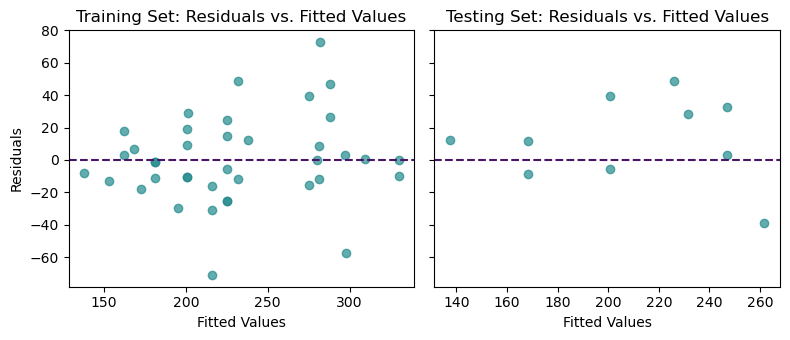

In [27]:
# Check the residuals have constant variance - one of the linear regression assumptions (homoscedasticity)

# Calculate residuals for training and testing sets
train_residuals = y_train - y_pred  # Replace y_train_pred with your train predictions
test_residuals = y_test - y_test_pred    # Replace y_test_pred with your test predictions

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharey=True)

# Residuals vs. Fitted Values for Training Set
axes[0].scatter(y_pred, train_residuals, alpha=0.7, color = '#238A8DFF')
axes[0].axhline(0, color='#481567FF', linestyle='--')
axes[0].set_title('Training Set: Residuals vs. Fitted Values')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')

# Residuals vs. Fitted Values for Testing Set
axes[1].scatter(y_test_pred, test_residuals, alpha=0.7, color = '#238A8DFF')
axes[1].axhline(0, color='#481567FF', linestyle='--')
axes[1].set_title('Testing Set: Residuals vs. Fitted Values')
axes[1].set_xlabel('Fitted Values')
# Y-axis label is shared with the first plot

# Adjust layout
plt.tight_layout()
plt.savefig('homoscedasticity', bbox_inches = 'tight')
plt.show()

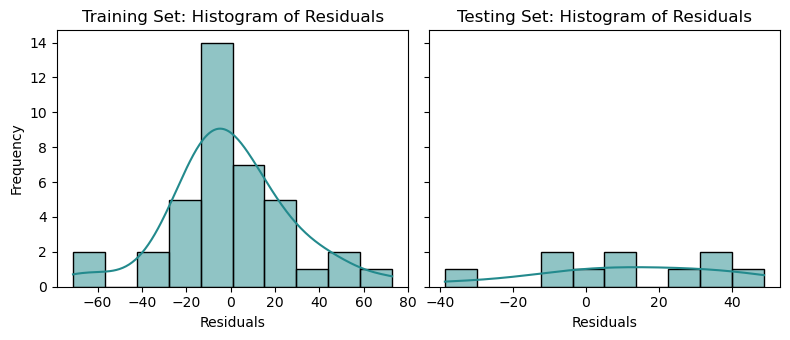

In [28]:
# Check the residuals are normally distributed - one of the linear regression assumptions (normality)

# Create subplots for side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharey=True)

# Training Set Histogram
sns.histplot(train_residuals, kde=True, ax=axes[0], color="#238A8DFF", bins=10)
axes[0].set_title('Training Set: Histogram of Residuals')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')

# Testing Set Histogram
sns.histplot(test_residuals, kde=True, ax=axes[1], color="#238A8DFF", bins=10)
axes[1].set_title('Testing Set: Histogram of Residuals')
axes[1].set_xlabel('Residuals')
# Y-axis label is shared with the first plot

# Adjust layout
plt.tight_layout()
plt.savefig('normality', bbox_inches = 'tight')
plt.show()

### Save the model for use in Streamlit

In [30]:
# Save the model to a pickle file

with open('LinRegModel.sav', 'wb') as file: 
    pickle.dump(ridge, file, protocol=pickle.HIGHEST_PROTOCOL)
file.close()